# R tutorial: Working with EMODnet data
#### Written by Pascal Derycke (EMODnet Secretariat) and Laurent Dubroca (Ifremer), edited by Tim Collart (EMODnet Secretariat) and Lennert Schepers (VLIZ)

We will use following R packages which first need to be installed in your Google Collab instance. **This will take several minutes to complete.**

In [1]:
# install gdal
system('sudo apt-get update')
system('sudo apt-get install libgdal-dev libproj-dev')
# install required R packages
install.packages(c("rgdal","raster","mapdata","maptools","downloader","directlabels","rasterVis","XML","ncdf4","kableExtra","rjson"), repos='http://cran.rstudio.com/')

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘sp’, ‘maps’, ‘quadprog’, ‘latticeExtra’, ‘hexbin’, ‘zoo’, ‘webshot’




Now that they are installed, we need to load them into memory:

In [0]:
# load dependencies
## geospatial data handling
library(rgdal)
library(raster)
library(sp)
library(mapdata)
library(maptools)
library(ncdf4)
## general data handling
library(XML)
library(dplyr)
library(tidyr)
library(reshape2)
library(downloader)
## plotting
library(directlabels)
library(rasterVis)
library(ggplot2)
## for display reasons
library(knitr)
library(kableExtra)
library(IRdisplay)
library(repr)

Loading required package: sp

rgdal: version: 1.4-8, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-2 

Loading required package: maps

Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching pac

# OGC Web Services

In stead of downloading EMODnet data to your local machine before using it for your application,  you can also access data directly from the web into your data analysis environment. In this tutorial, we will use the [statistical programming language R](https://www.r-project.org/) to access EMODnet map images, data and metadata.

The EMODnet data portals allow web acces to map images, data and metadata through [Open Geospatial Consortium Web Services](https://www.opengeospatial.org/standards/owc). This is a set of standards which allow to transfer geospatial data and metadata over the web. We will show following services available from EMODnet:

* [Web Map Service (WMS)](https://www.opengeospatial.org/standards/wms): Allows you to download geo-referenced map images

* [Web Feature Service (WFS)](https://www.opengeospatial.org/standards/wfs): Allows you to download geospatial vector data

* [Web Coverage Service (WCS)](https://www.opengeospatial.org/standards/wcs): Allows you to download geospatial raster data

* [Catalogue Service for the Web (CSW)](https://www.opengeospatial.org/standards/cat): Allows you to search the catalogue of metadata to find the dataset you are looking for.

The full list of URL's you need to access data (Web Service Doucmentation) and metadata (Web Service Catalogue) from EMODnet is availble on the [Open Sea Lab Website](http://www.opensealab.eu/data2019). The exercises below cover some specific examples of how to acces and search for the data you require for your applications. You are free to use and modify this code in your own work.



---


During the first four exercises, we focus on the Pertuis Charentais Marine Protected Area (MPA) in France. The shapefile for this area can be downloaded from the [World Database on Protected Areas (WDPA)](https://www.protectedplanet.net/pertuis-charentais-site-of-community-importance-habitats-directive).

In [0]:
# download and unzip the shapefile
con = "https://www.protectedplanet.net/downloads/WDPA_Jan2020_protected_area_555526224?type=shapefile"
download(con,"shapefile.zip", mode = "wb")
unzip("shapefile.zip",exdir="MPA")
# read it into R
mpa = readOGR("MPA","WDPA_Jan2020_protected_area_555526224-shapefile-polygons")
# get the spatial extent of the MPA
#xmin <- extent(mpa)@xmin
#ymin <- extent(mpa)@ymin
xmax <- extent(mpa)@xmax
ymax <- extent(mpa)@ymax

OGR data source with driver: ESRI Shapefile 
Source: "/content/MPA", layer: "WDPA_Jan2020_protected_area_555526224-shapefile-polygons"
with 1 features
It has 28 fields


We make some maps to show the location of the MPA.

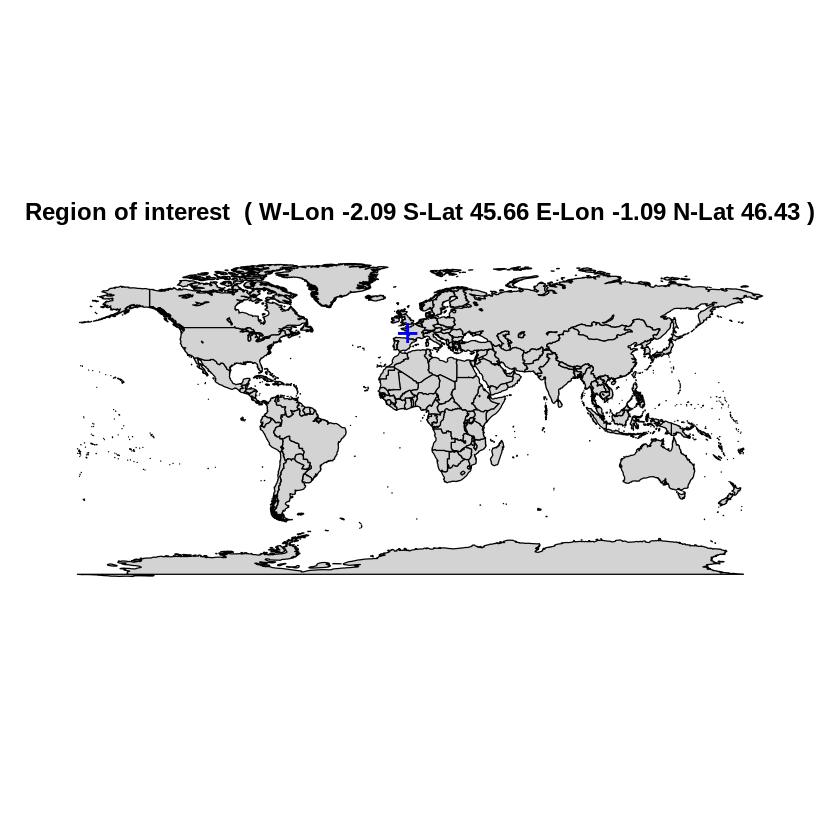

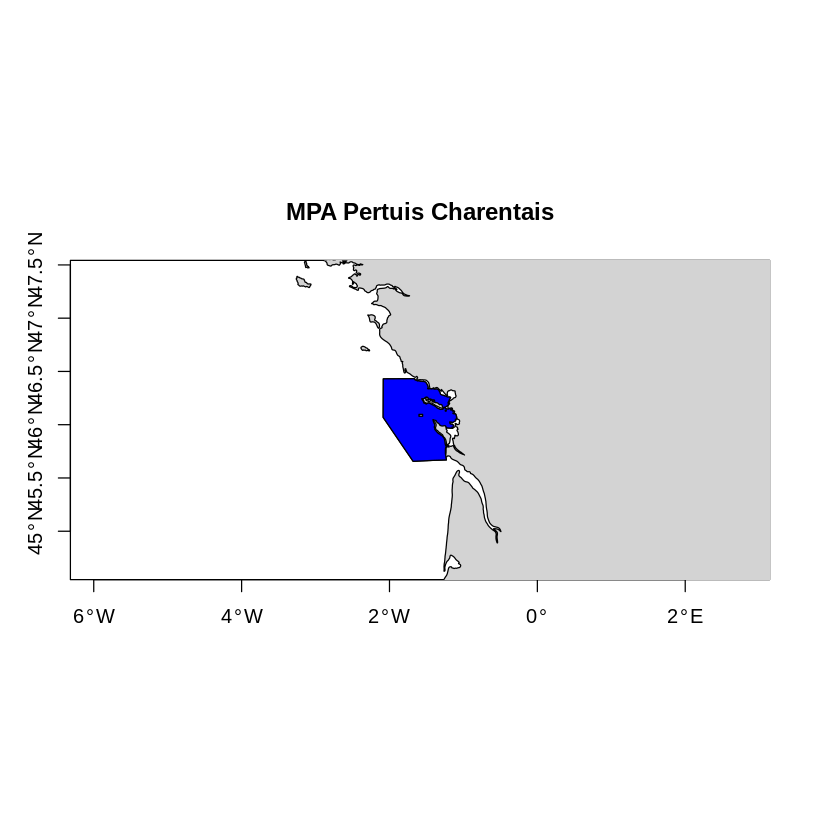

In [0]:
# Localisation at global scale
map("worldHires",col="light grey",fill=T)
points(coordinates(mpa),cex=2,col="blue",pch="+")
title(paste("Region of interest ",
            "( W-Lon",round(xmin,2),
            "S-Lat",round(ymin,2),
            "E-Lon",round(xmax,2),
            "N-Lat",round(ymax,2),")"),cex=.5)

# Localisation at local scale
plot(mpa,xlim=c(xmin-1,xmax+1),ylim=c(ymin-1,ymax+1),axes=T,col="red")
map("worldHires",add=T,col="light grey",fill=T)
plot(mpa,add=T,col="blue")
title(paste("MPA",mpa$ORIG_NAME),cex=.5)

# Working with data from EMODnet bathymetry

## Access raster data through Web Coverage Service (WCS)

Using the EMODnet Bathymetry WCS, we will download the bathymetric data within the MPA.

In [0]:
# Define a function to read in raster data from the EMODnet bathymetry WCS
getbathymetry<-function (name = "emodnet:mean", xmin = 15, xmax = 20.5, ymin = 30, ymax = 32.5){
  bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")
                              
  con <- paste("https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",
               name,"&crs=EPSG:4326&BBOX=", bbox,
               "&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333", sep = "")
  
  print(con)
  
  stop   
  nomfich <- paste(name, "img.tiff", sep = "_")
  nomfich <- tempfile(nomfich)
  download(con, nomfich, quiet = TRUE, mode = "wb")
  img <- raster(nomfich)
  img[img == 0] <- NA
  img[img < 0] <- 0
  names(img) <- paste(name)
  return(img)
}

# get the bathymetry data for the MPA
bathy_img <- getbathymetry(name = "emodnet:mean", xmin, xmax, ymin, ymax)
bathy<- as.data.frame(as(bathy_img, "SpatialPixelsDataFrame")) 

[1] "https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=-2.08542634399993,45.656434726,-1.08908527599993,46.431984179&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333"


## Creating maps

We plot the bathymetry to see if everything is ok.

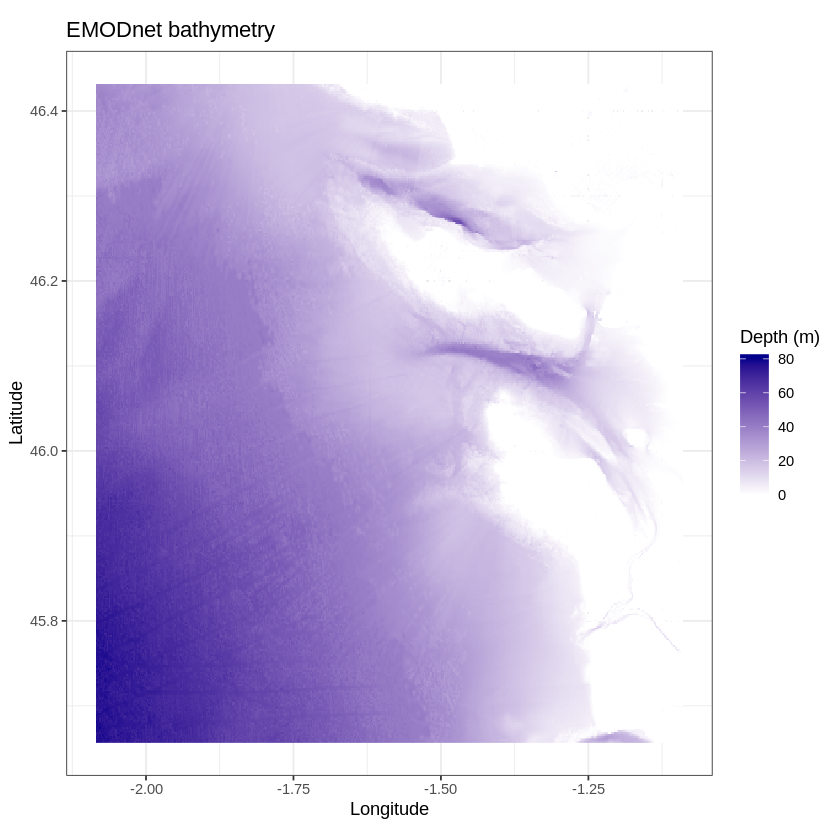

In [0]:
map <- ggplot(aes(x=x, y=y, z=emodnet.mean), data = bathy) +
  geom_raster(data=bathy, aes(fill=emodnet.mean)) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet bathymetry")+xlab("Longitude")+ylab("Latitude") +
  theme_bw()

map

We can overlie the bathymetry with the shape of the MPA

Regions defined for each Polygons


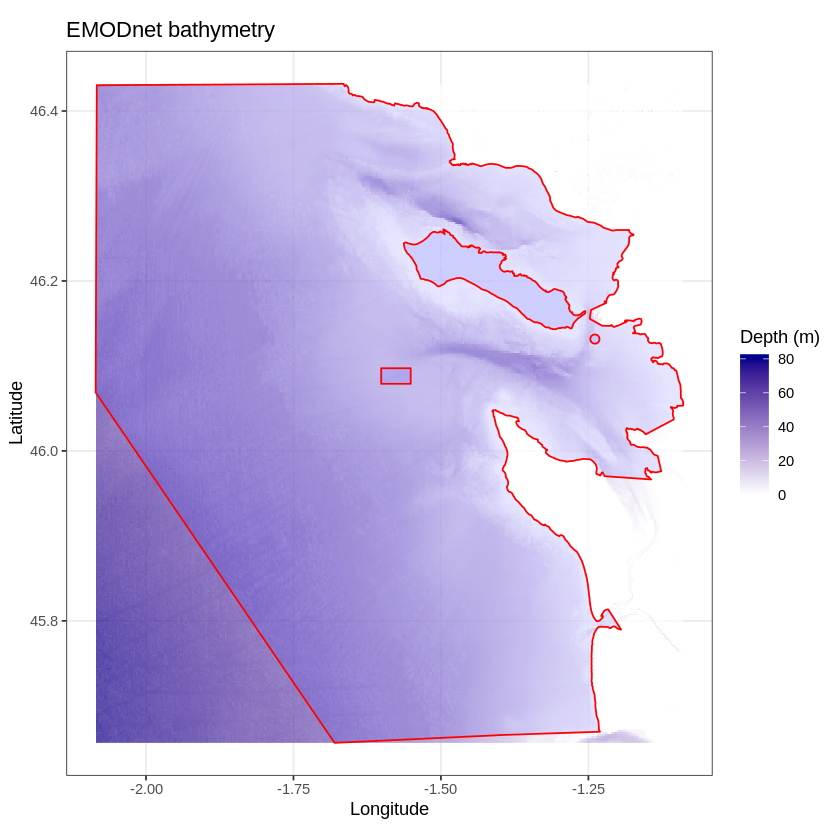

In [0]:
map_mpa <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_polygon(data=mpa,aes(x=long,y=lat,group=group,fill="mpa"),colour="red",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet bathymetry")+xlab("Longitude")+ylab("Latitude") 
 
map_mpa

We can also calculate and plot isobaths.

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

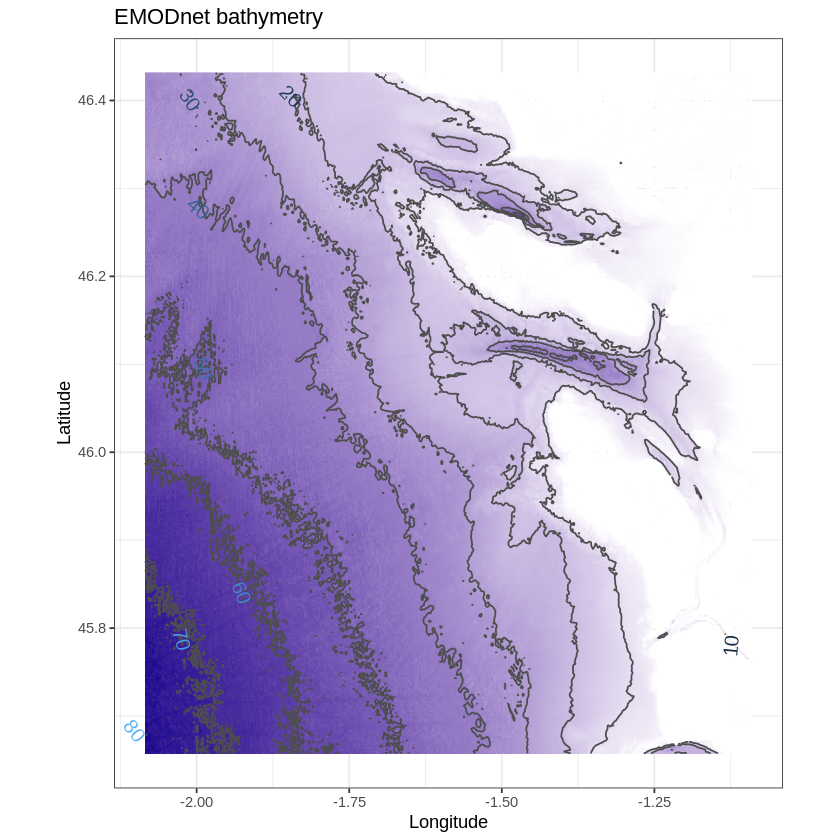

In [0]:
map_iso	<- map + geom_contour(aes(colour = ..level..), color='gray30', na.rm=T, show.legend=T)
map_isobath = direct.label(map_iso, list("far.from.others.borders", "calc.boxes", "enlarge.box", 
      hjust = 1, vjust = 1, box.color = NA, fill = "transparent", "draw.rects"))
map_isobath

For mapping raster data, we can also use the `rasterVis` package to create level plots.

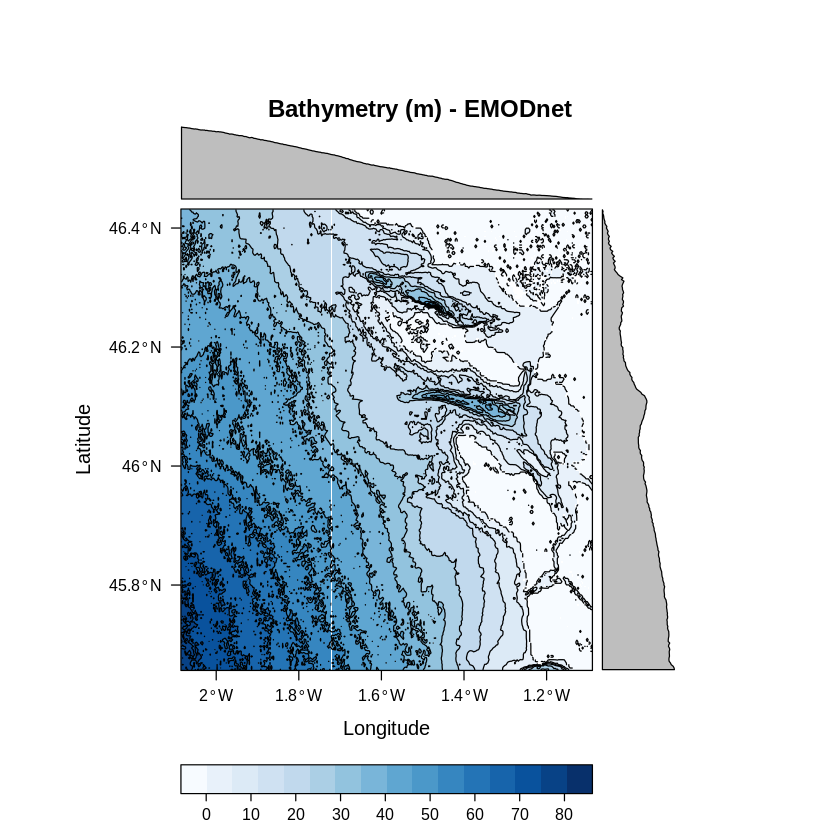

In [0]:
pltbathy <- rasterVis::levelplot(bathy_img, margin = TRUE, contour=T, main="Bathymetry (m) - EMODnet",
                                 par.settings=rasterTheme(region=brewer.pal('Blues', n=9)))
pltbathy

## Creating 3D visualisations

Using the `persp()` function we can also make 3D visualisations.

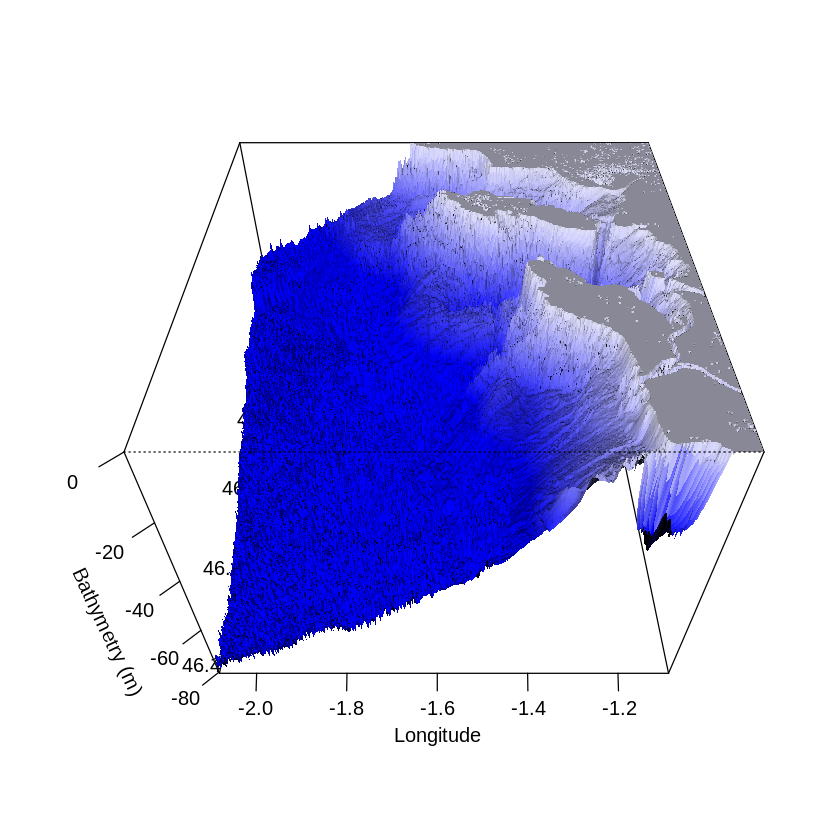

In [0]:
bathymetry.col<-function (n, alpha = 1){
  if ((n <- as.integer(n[1L])) > 0){
    j <- n%/%3
    k <- n%/%3
    i <- n - j - k
    c(if (i > 0) hsv(h = seq.int(from = 40/60, to = 40/60, length.out = i), alpha = alpha),
      if (j > 0) hsv(h = seq.int(from = 40/60, to = 40/60, length.out = j), alpha = alpha),
      if (k > 0) hsv(h = seq.int(from = 40/60, to = 40/60, length.out = k), alpha = alpha, s = seq.int(from = 1, to = 0.1, length.out = k),v = 1))
  }
  else character()
}

bathymetry3d <- -1*bathy_img
bathymetry3d[is.na(bathymetry3d)] <- 0
bathymetry3d[bathymetry3d > 0] <- 0

summary.elev <- summary(bathymetry3d)
setBaseElev <- function(x) {
  x[is.na(x)] <- as.numeric(summary.elev[1])
  return(x)
}
elev3D <- calc(bathymetry3d, setBaseElev)
zBathy <-round(as.matrix(elev3D),1)
y <- dim(zBathy)[1]
x <- dim(zBathy)[2]

nlat <- y
nlon <- x

nrz <- nrow(zBathy)
ncz <- ncol(zBathy)
zfacet <- (zBathy[-1, -1] + zBathy[-1, -ncz] + zBathy[-nrz, -1] + zBathy[-nrz, -ncz])/4
nbcol <- 254
color <- c("grey", bathymetry.col(nbcol))
facetcol <- cut(zfacet, nbcol+1)

steplat=(ymax-ymin)/nlat
steplon=(xmax-xmin)/nlon

latitude <- numeric(nlat)
for(i in 1:nlat){
  latitude[i]<-ymin+(i+0.5)*steplat
}

longitude <- numeric(nlon)
for(i in 1:nlon){
  longitude[i]<-xmin+(i+0.5)*steplon
}

img3d<- persp(latitude, longitude, z = zBathy, theta = 90, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="Longitude", zlab="Bathymetry (m)")

## Exporting graphics 

The maps and 3D visualisation can be exported to images (e.g. PNG's).

In [0]:
# determine dimensions of the images
width <- 960
height <- as.integer(width * (ymax-ymin) / (xmax-xmin))

#create unique id for the filenames
Sessionid = "OSLII_"

# output maps
png(file=paste(Sessionid,"_bathymetry2d_isobath.png",sep=""), width, height)
print(map_isobath)
dev.off()

png(file=paste(Sessionid,"_bathymetry2d_isobath_alt.png",sep=""), width, height)
print(pltbathy)
dev.off()

# output 3d visualisations

png(file=paste(Sessionid,"_bathymetry3d_90.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 90, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()

png(file=paste(Sessionid,"_bathymetry3d_0.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 0, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()

png(file=paste(Sessionid,"_bathymetry3d_180.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 180, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()


png(file=paste(Sessionid,"_bathymetry3d_270.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 270, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

png 
  2

png 
  2

              [,1]          [,2]          [,3]          [,4]
[1,]  1.583326e-16 -1.828414e+00  1.828414e+00 -1.828414e+00
[2,]  2.011553e+00  1.741917e-16 -1.232595e-32  1.232595e-32
[3,] -1.139560e-18  1.315956e-02  1.315956e-02 -1.315956e-02
[4,]  3.188656e+00  8.472202e+01 -8.639341e+01  8.739341e+01


png 
  2

            [,1]       [,2]        [,3]        [,4]
[1,]    2.585768 0.00000000  0.00000000  0.00000000
[2,]    0.000000 1.42238277 -1.42238277  1.42238277
[3,]    0.000000 0.01315956  0.01315956 -0.01315956
[4,] -119.065027 2.78505060 -4.45644123  5.45644123


png 
  2

              [,1]          [,2]         [,3]          [,4]
[1,] -2.585768e+00 -2.239161e-16 2.239161e-16 -2.239161e-16
[2,]  2.463442e-16 -1.422383e+00 1.422383e+00 -1.422383e+00
[3,] -1.395558e-34  1.315956e-02 1.315956e-02 -1.315956e-02
[4,]  1.190650e+02 -1.724390e+00 5.299979e-02  9.470002e-01


png 
  2

              [,1]          [,2]          [,3]          [,4]
[1,] -4.749978e-16  1.828414e+00 -1.828414e+00  1.828414e+00
[2,] -2.011553e+00 -1.741917e-16  3.483833e-16 -3.483833e-16
[3,]  1.139560e-18  1.315956e-02  1.315956e-02 -1.315956e-02
[4,] -3.188656e+00 -8.366136e+01  8.198997e+01 -8.098997e+01


png 
  2

## Summarising raster data

From the raster data, we can derive statistics like the average depth and the standard deviations.

In [0]:
values <- getValues(bathy_img$emodnet.mean)

# calcualte the average depth
m <- mean(values,na.rm=T)
m

# calculate the standard deviation
std_dev <- sd(values,na.rm=T)
std_dev

[1] 26.20601

[1] 21.42333

## Exporting data

### Exporting raster data

Using the `ncdf4` package, we can export the raster data to the netCDF format. The created netCDF file can then be used in other applications like [Panoply](https://www.giss.nasa.gov/tools/panoply/download).

In [0]:
writeRaster(bathy_img, "EMODnet_bathymetry_555526224.nc", format="CDF", force_v4=TRUE, compression=7, overwrite=TRUE)

class      : RasterLayer 
dimensions : 372, 478, 177816  (nrow, ncol, ncell)
resolution : 0.002084396, 0.00208481  (x, y)
extent     : -2.085426, -1.089085, 45.65643, 46.43198  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /content/EMODnet_bathymetry_555526224.nc 
names      : emodnet.mean 
values     : 0, 80.6  (min, max)
zvar       : emodnet.mean 


### Exporting vector data

The MPA shapefile can be exported in geoJSON format

In [0]:
writeOGR(mpa,dsn = "mpa.json", layer="mpa",driver="GeoJSON")

## Accessing the original survey data

The EMODnet bathymetry data we have used throughout this exercise is a dataproduct that was calculated from a number of individual bathymetric surveys. In case we want to find the original survey data, EMODnet bathymetry provides a dataset with the outline of each of the individual surveys as well as their identification. In the script below, we access this source reference (vector) data using WFS (see Exercise 2) and investigate the different surveys in the MPA.

OGR data source with driver: GeoJSON 
Source: "https://ows.emodnet-bathymetry.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=emodnet:source_references&OUTPUTFORMAT=json&bbox=-2.08542634399993,45.656434726,-1.08908527599993,46.431984179", layer: "OGRGeoJSON"
with 188 features
It has 8 fields, of which 1 list fields
[1] "https://ows.emodnet-bathymetry.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=emodnet:source_references&OUTPUTFORMAT=json&bbox=-2.08542634399993,45.656434726,-1.08908527599993,46.431984179"


Regions defined for each Polygons


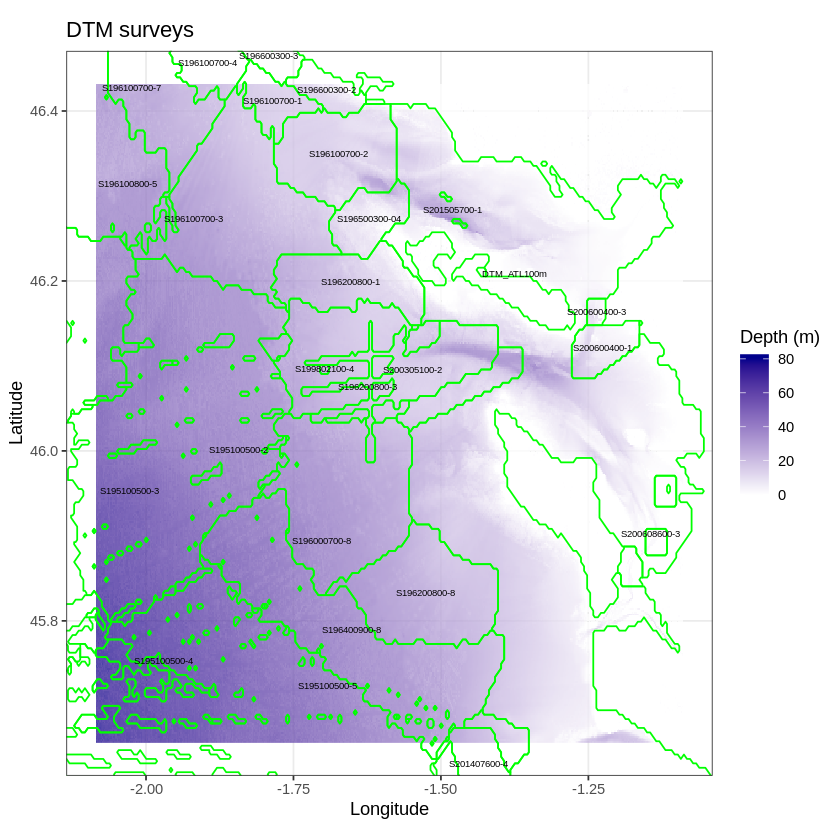

In [0]:
# define a function to access the survey vector data using WFS
getDTMgeojson<-function(name="DTM_Surveys",xmin=-1,xmax=1,ymin=49,ymax=50){
  name<-as.character(name)
  bbox<-paste(xmin,ymin,xmax,ymax,sep=",")
  con<-paste0("https://ows.emodnet-bathymetry.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=",
  name,"&OUTPUTFORMAT=json&bbox=",bbox)
  ogrInfo(dsn=con,layer = 'OGRGeoJSON')
  layer<-readOGR(dsn=con,layer = 'OGRGeoJSON')
  print(con)
  return(layer)
}

# load the data
DTM_Surveys<-getDTMgeojson(name="emodnet:source_references",xmin,xmax,ymin,ymax)

#create a data frame to plot identifier on top of polygons
centroid <- aggregate(coordinates(DTM_Surveys) ~ identifier, data=DTM_Surveys, FUN=mean)
names(centroid) <- c("Name", "Longitude", "Latitude")

map <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  # annotate("text", x=-1.5, y=46, label= "boat") +
  geom_polygon(data=DTM_Surveys,aes(x=long,y=lat,group=group,fill="DTM_Surveys"),colour="green",fill=NA) +
  # geom_text(check_overlap = TRUE) +
  geom_text(data=centroid, aes(label = Name, x = Longitude, y = Latitude), size=2, check_overlap = TRUE) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax))+
  ggtitle("DTM surveys")+xlab("Longitude")+ylab("Latitude")

map

Finally, we export the survey dataset to a shapefile.

In [0]:
writeOGR(DTM_Surveys,dsn = "DTM_Surveys", layer="Survey_outlines",driver="ESRI Shapefile", overwrite_layer = TRUE)

# Working with data from EMODnet human activities

## Access vector data with WFS

The WFS of the EMODnet Human Activities portal allows collecting all kind of information for the MPA.

https://ows.emodnet-humanactivities.eu/wfs?service=WFS&request=GetCapabilities&version=1.1.0

### Point data

In this tutorial, we access point data from EMODnet Human Activities within the desired region of interest (the MPA) as a csv file.

To get/read the names of the columns of the layer (in this case "shellfish"):

* https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=describeFeatureType&typeName=shellfish&OUTPUTFORMAT=application/json&bbox=-1.3,0.3,49.2,49.9
* https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=describeFeatureType&typeName=shellfish&bbox=-1.3,0.3,49.2,49.9
* https://ows.emodnet-humanactivities.eu/wfs?service=wfs&version=2.0.0&request=DescribeFeatureType
* https://ows.emodnet-humanactivities.eu/wfs?service=wfs&version=2.0.0&request=GetPropertyValue&typeNames=shellfish&valueReference=the_geom&bbox=-1.3,0.3,49.2,49.9

Note: featureID and bbox are mutually exclusive:

* https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=shellfish&OUTPUTFORMAT=csv&bbox=-1.3,0.3,49.2,49.9&featureID=the_geom

In [0]:
# define a function to download the WFS data as a csv file 
gethumactpoint<-function(name="shellfish",xmin=-1000,xmax=1000,ymin=-1000,ymax=1000){
  name <- as.character(name)
  bbox <- paste(xmin,xmax,ymin,ymax,sep=",")
  con <- paste0("https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=",name,"&OUTPUTFORMAT=csv&bbox=",bbox)
  utils::download.file(con,"dat.csv", quiet = TRUE, mode = "wb")
  pipo <- utils::read.csv("dat.csv")
  # if no data return empty dataframe
  if(ncol(pipo)<=1){
    return(data.frame())
  }
  # convert coordinates to numeric type
  else{
    xy <- strsplit(gsub("\\)","",gsub("POINT \\(","",pipo$the_geom)),split=" ")
    fun1 <- function(a){as.numeric(a[1])}
    fun2 <- function(a){as.numeric(a[2])}
    pipo$y <- sapply(xy,fun1)
    pipo$x <- sapply(xy,fun2)
    return(pipo)
  }
}

# function to format the dataframe
gethumactpointall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9)
{
  layer="shellfish"
  #layer="windfarmspoly"
  #layer="windfarms"
  #layer="subunitcatches"
  #layer="subdivisioncatches"
  #layer="subareacatches"
  #layer="sigcables"
  #layer="portvessels"
  #layer="macroalgae"
  #layer="aggregates"
  
  # get csv file
  rez0 <- gethumactpoint(layer, ymin, xmin, ymax, xmax)
  # format dataframe
  if (nrow(rez0) > 0){
    ha <- data.frame(type = layer,
                     status = rez0$site_typology,
                     purpose = "",
                     info = rez0$species,
                     name = rez0$site_name,
                     country = rez0$country,
                     x = rez0$x,
                     y = rez0$y)
    rm(rez0)
  }
  return(ha)
}

# get the shellfish data 
ha<-gethumactpointall(xmin,xmax,ymin,ymax)


Investigate the downloaded data table and plot them on a map.

In [0]:
ha %>% knitr::kable(floating.environment="sidewaystable") %>%  as.character() %>% display_html()

type 
 status 
 purpose 
 info 
 name 
 country 
 x 
 y 
 
 
 
 
 shellfish 
 Production area 
 
 Oysters 
 Estuaire du Payre 
 France 
 -1.661782 
 46.43094 
 
 
 shellfish 
 Production area 
 
 Mussels, Oysters 
 Pertuis Breton 
 France 
 -1.319160 
 46.28812 
 
 
 shellfish 
 Production area 
 
 Oysters 
 Ile de Re 
 France 
 -1.461983 
 46.18221 
 
 
 shellfish 
 Production area 
 
 Oysters 
 Ile d'Oleron 
 France 
 -1.314468 
 45.96261 
 
 
 shellfish 
 Production area 
 
 Oysters 
 Nord Charente (Fouras à La Rochelle) 
 France 
 -1.127586 
 46.08228 
 
 
 shellfish 
 Production area 
 
 Oysters 
 Sud Charente (Port des Barques à la Gironde) 
 France 
 -1.133194 
 45.91868 
 
 
 shellfish 
 Production area 
 
 Oysters 
 Baie de l'Aiguillon Sud 
 France 
 -1.165888 
 46.25769

Regions defined for each Polygons


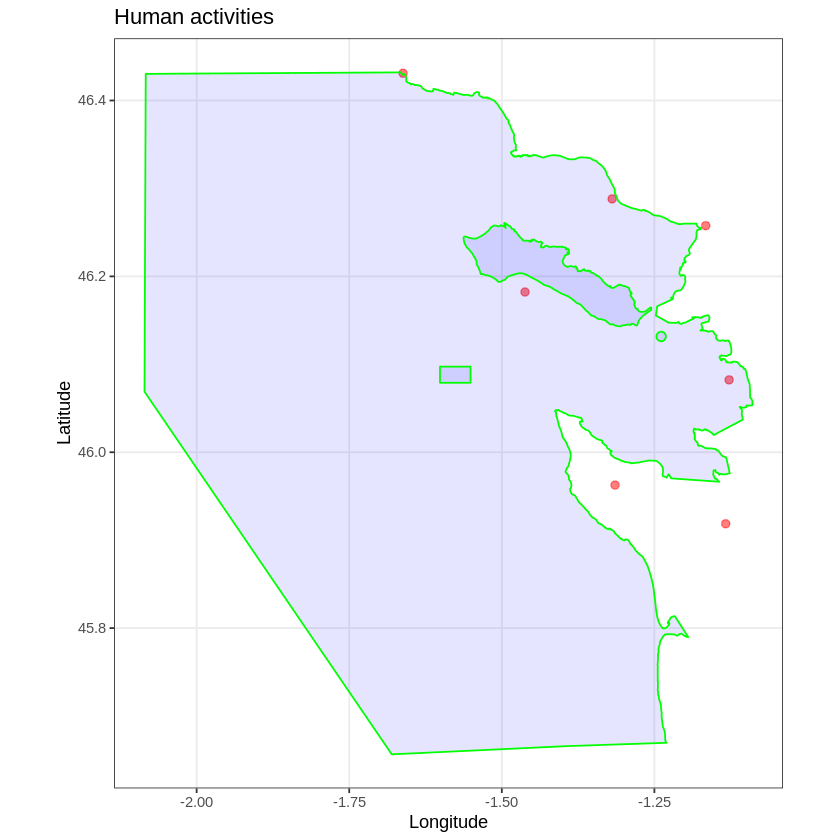

In [0]:
map <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_point(data=ha,aes(x=x,y=y),alpha=.5,color="red", size=2) +
  geom_polygon(data=mpa,aes(x=long,y=lat,group=group,fill="mpa"),colour="green",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("Human activities")+xlab("Longitude")+ylab("Latitude")

map

We can also combine several data layers in one table.

In [0]:
# a function to format and combine data from different layers
gethumactpointall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9){
  ha <- data.frame()
  rez0 <- gethumactpoint("finfish", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "finfish", status = rez0$status,
    purpose = rez0$purpose, info = rez0$species_harmonised,
    name = rez0$owner_name, country = rez0$country, x = rez0$x,
    y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("shellfish", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "shellfish", status = rez0$site_typology,
    purpose = "", info = rez0$species, name = rez0$site_name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("dredging", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "dredging", status = rez0$purpose,
    purpose = rez0$extraction_type, info = rez0$extraction_area,
    name = rez0$areaid, country = rez0$country, x = rez0$x,
    y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("hydrocarbons", ymin, xmin, ymax,
  xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "hydrocarbons", status = rez0$status,
    purpose = rez0$purpose, info = rez0$company, name = rez0$name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("aggregates", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "aggregates", status = rez0$notes,
    purpose = rez0$purpose, info = rez0$extraction_type,
    name = rez0$extraction_area, country = rez0$country,
    x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("platforms", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "platforms", status = rez0$class,
    purpose = rez0$primary_production, info = rez0$category,
    name = rez0$name, country = rez0$country, x = rez0$x,
    y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("windfarms", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "windfarms", status = rez0$status,
    purpose = rez0$power_mw, info = "", name = rez0$name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("dredgespoil", ymin, xmin, ymax, xmax)
    if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "dredgespoil", status = "",
    purpose = "", info = rez0$oscom_code, name = rez0$name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("munitions", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "munitions", status = "", purpose = "",
    info = rez0$munition_type, name = "", country = "",
    x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }

return(ha)
}

# get the data
ha <- gethumactpointall(xmin,xmax,ymin,ymax)

Warning message in `[<-.factor`(`*tmp*`, ri, value = 500L):
“invalid factor level, NA generated”

Plot the human activity data on map with the EMODnet bathymetry and the coastline data from the `mapdata` package. 

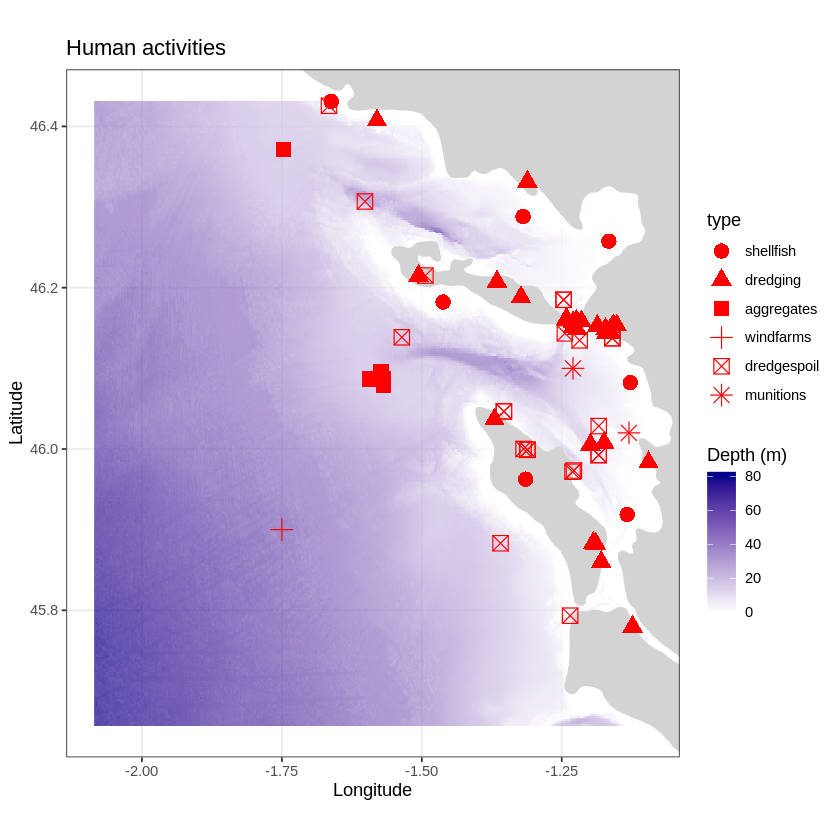

In [0]:
map <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  borders("worldHires",xlim=c(xmin,xmax),ylim=c(ymin,ymax),fill="light grey",colour="light grey") + 
  geom_point(data=ha,aes(x=x,y=y,shape=type,group=type),colour="red",alpha=1, size=4) +
  #geom_polygon(data=mpa,aes(x=long,y=lat,group=group,fill="mpa"),colour="green",fill="blue",alpha=.1)+
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax))+
  ggtitle("Human activities")+xlab("Longitude")+ylab("Latitude")

plot(map)

Finally, we export the point data to a csv file.

In [0]:
write.csv(ha, file = "Humanactivities.csv", row.names = FALSE)

### Polygon data

We can also access polygon data as a geoJSON file with WFS. Here we download the natura2000 sites.

In [0]:
# define a function to read the WFS data as a geoJSON file
gethumactgeojson<-function(name="natura2000areas",xmin=-1,xmax=1,ymin=49,ymax=50){
  name <- as.character(name)
  bbox <- paste(xmin,ymin,xmax,ymax,sep=",")
  con <- paste0("https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=",name,"&OUTPUTFORMAT=application/json&bbox=",bbox)
  ogrInfo(dsn=con,layer = 'OGRGeoJSON')
  layer <- readOGR(dsn=con,layer = 'OGRGeoJSON')
  print(con)
  return(layer)
}

# get data
natura2000 <- gethumactgeojson(name="natura2000areas",xmin,xmax,ymin,ymax)

OGR data source with driver: GeoJSON 
Source: "https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=natura2000areas&OUTPUTFORMAT=application/json&bbox=-2.08542634399993,45.656434726,-1.08908527599993,46.431984179", layer: "OGRGeoJSON"
with 24 features
It has 17 fields
[1] "https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=natura2000areas&OUTPUTFORMAT=application/json&bbox=-2.08542634399993,45.656434726,-1.08908527599993,46.431984179"


We can now overlay our map with the natura2000 sites.

Regions defined for each Polygons


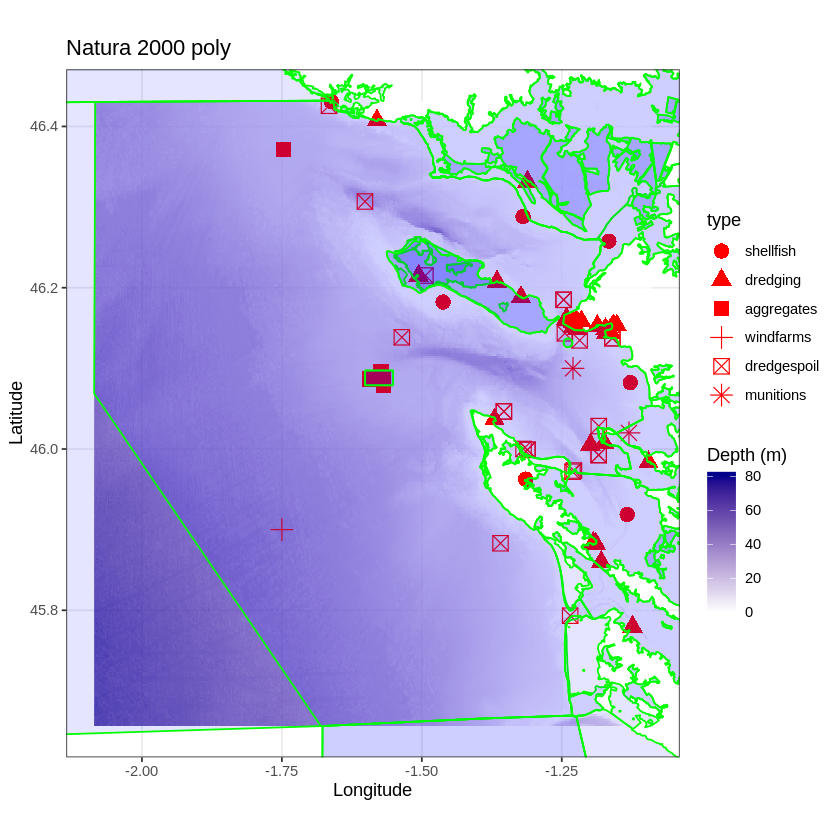

In [0]:
map <- ggplot()+
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_point(data=ha,aes(x=x,y=y,shape=type,group=type),colour="red", alpha=1, size=4) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="green",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("Natura 2000 poly")+xlab("Longitude")+ylab("Latitude")

map

Finally, we export the polygon data to a geoJSON file.

In [0]:
writeOGR(natura2000, dsn = 'natura2000.json', layer="natura2000",driver="GeoJSON")

## Access raster time series data with WCS

EMODnet human activities offers monthly datasets of vessel density for each type of vessel. With the script below we are downloading the vessel density data  for each month and each vessel type using the EMODnet human activities WCS.

In [0]:
# define a function to access vessel density data from the EMODnet human activities WCS
getvesseldensityLite <- function(name = "emodnet:2017_01_st_All", resolution = "30 arcsec / 900m", xmin = 15, xmax = 20.5, ymin = 30, ymax = 32.5){
  bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")                           
  con <- paste("https://ows.emodnet-humanactivities.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",name,"&crs=EPSG:4326&BBOX=", bbox, "&format=image/tiff&interpolation=nearest&resx=0.00833333&resy=0.00833333", sep = "") 
  nomfich <- paste(name, "img.tiff", sep = "_")
  nomfich <- tempfile(nomfich)
  download(con, nomfich, quiet = TRUE, mode = "wb")
  img <- raster(nomfich)
  img[img == 0] <- NA
  names(img) <- paste(name)
  return(img)
}

# define a function to make a rasterstack of monhtly vessel density data
createmonthlystack <- function(name = "emodnet:2017_",
                               vessel_type = "All",
                               resolution  = "30 arcsec",
                               xmin = 15, xmax = 20.5,
                               ymin = 30, ymax = 32.5){
  imgs <- stack()
  for (month in c('01','02','03','04','05','06','07','08','09','10','11','12')){
    img <- getvesseldensityLite(name = paste(name,month,"_st_",vessel_type, sep=""), resolution = resolution, xmin, xmax, ymin, ymax)
	  imgs <- stack(imgs,img)
  }
  return(imgs)
}

# create dataframe of vessel types
vesseltypes <- cbind.data.frame(type_id = c('All','00','01','02','03','04','05','06','07','08','09','10','11','12'),
                             type_name = c("ALL","OTHER","FISHING","SERVICE","DREDGING","SAILING","PLEASURE",
                                                 "HIGHSPEED","TUG","PASSENGER","CARGO","TANKER","MILITARY","UNKNOWN"),
                             stringsAsFactors=FALSE)

# loop over the different vessel types and create a stack for each one, combining them in a list
mpa_vessel_density_per_type = list()
for(i in 1:nrow(vesseltypes)){
  mpa_vessel_density_per_type[[vesseltypes[i,"type_name"]]] = createmonthlystack(vessel_type = vesseltypes[i,"type_id"],
                                                                               xmin = xmin, xmax=xmax,
                                                                               ymin = ymin, ymax=ymax)
}

We visualise these data by making monthly maps as well as a yearly average for a selected vessel type.

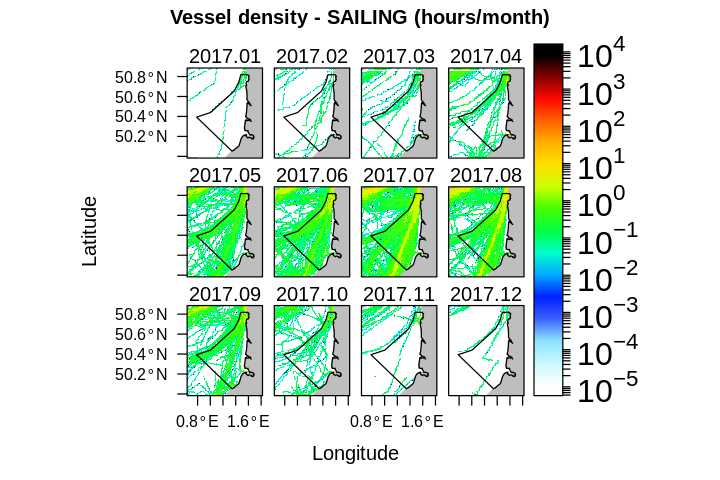

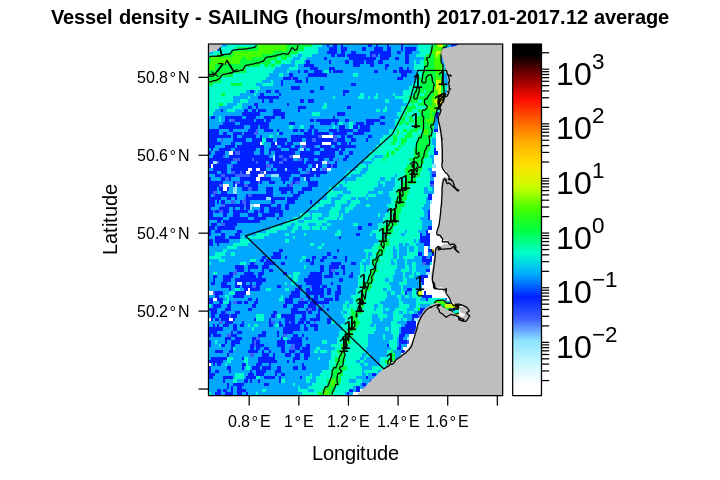

In [0]:
# define a function to map the density maps, average yearly density and monthly climatology
mpaprocessplot<-function (imgs, mpa, name, unite, logscale) 
{
    if (dim(imgs)[3] < 12) {
        print("Series is too short (ie less than 12 months)")
    }
    else {
  		col.l <- colorRampPalette(c('white','cadetblue1','blue','cyan','green','yellow','orange','red','black'))
  		#col.l <- colorRampPalette(c('blue','cyan','green','yellow','orange','red','black'))
  		#imgs[imgs > 100] <- 100
  		ckey <- list(labels=list(cex=1.6, col='black'), height=1.0)
	
      imgsmean <- raster::mean(imgs, na.rm = T)

  	  
      
      # plot monthly data
      titre <- paste(name, " (", unite, ")", sep = "")
      pltall <- rasterVis::levelplot(imgs,
                                     zscaleLog = logscale, contour = F, 
                                     col.regions = col.l, colorkey=ckey,
                                     layout = c(4, NA),
                                     names = sub(".*(2017)_([0-9]{2})_.*","\\1.\\2",names(imgs)),
                                     main=list(label=titre, cex=1))
  
      titre <- paste(name, " (", unite, ") ",
                     sub(".*(2017)_([0-9]{2})_.*","\\1.\\2",names(imgs)[1]),
                     "-",
                     sub(".*(2017)_([0-9]{2})_.*","\\1.\\2",names(imgs)[dim(imgs)[3]]),
                     " average", sep = "")
      pltmean <- rasterVis::levelplot(imgsmean, margin = F,
                                      zscaleLog = logscale,contour = F,
                                      col.regions = col.l,  colorkey=ckey,
                                      main=list(label=titre, cex=1)) +
      contourplot(imgsmean, at = c(0,1,10,20,40,60) , labels = T)
  	
      titre <- paste(name, " (", unite, ") monthly boxplot", sep = "")
      pltbw <- rasterVis::bwplot(crop(imgs, extent(mpa)),logscale = T,
          scales = list(x = list(labels = names(imgs))), 
          main=list(label=titre, cex=1))
      
      return(list(pltall = pltall,
                  pltmean = pltmean,
                  pltbw = pltbw))
      }
}

# get a coastline shape
mappoly<-map("worldHires",fill=T,plot=FALSE,xlim=c(extent(mpa)@xmin-1,extent(mpa)@xmax+1),ylim=c(extent(mpa)@ymin-1,extent(mpa)@ymax+1))
IDs <- sapply(strsplit(mappoly$names, ":"), function(x) x[1])
coast<- map2SpatialPolygons(mappoly, IDs=IDs, proj4string=CRS("+proj=longlat +datum=WGS84"))

# make plots for the desired vessel types
types_to_plot= c("SAILING")
for(type in types_to_plot){
  plt_vessel <- mpaprocessplot(imgs = mpa_vessel_density_per_type[[type]],
                               mpa=mpa,
                               name=paste("Vessel density",type, sep=" - "),unite="hours/month",
                               logscale= !(type %in% c("HIGHSPEED","UNKNOWN"))) # too little data in these types to have a logscale
  #print map of the whole series
  img1 <- plt_vessel[[1]]+latticeExtra::layer(sp.polygons(coast,fill="grey",col="grey"))+latticeExtra::layer(sp.polygons(mpa))
  print(img1)
  #print map of the average 
  img2 <- plt_vessel[[2]]+latticeExtra::layer(sp.polygons(coast,fill="grey",col="grey"))+latticeExtra::layer(sp.polygons(mpa))
  print(img2)
  
  # save images as PNG
  png(file=paste("VESSEL_monthly_composite-",type,".png",sep=""),width = 960, height = 960)
  print(img1)
  dev.off()

  png(file=paste("VESSEL_average-",type,".png",sep=""),width = 960, height = 960)
  print(img2)
  dev.off()
}

Let's derive the average vessel density per month for our MPA.

In [0]:
# get the area of the mpa
mpa$area_sqkm <- area(mpa)/1000000

# extract the average fishing density in the mpa for each vessel type and month
data_csv = data.frame(MONTH = c(01,02,03,04,05,06,07,08,09,10,11,12))
for(type in vesseltypes$type_name){
  monthly_means = c()
  for(month in 1:12){
    datinpoly <- raster::extract(mpa_vessel_density_per_type[[type]][[month:month]],mpa,df = TRUE, cellnumbers = TRUE)
    tabdat <- as.vector(as.matrix(datinpoly[, 3:ncol(datinpoly)]))
    mean_value <- sum(tabdat, na.rm = T)/mpa$area_sqkm
    monthly_means = c(monthly_means, mean_value)
  }
  data_csv[type]= monthly_means
}

# export the data
#write.csv(data_csv, file="mpa_monthly_average_density_per_type", row.names=FALSE, na="NaN")

Let us plot the time series of the averaged vessel density data.

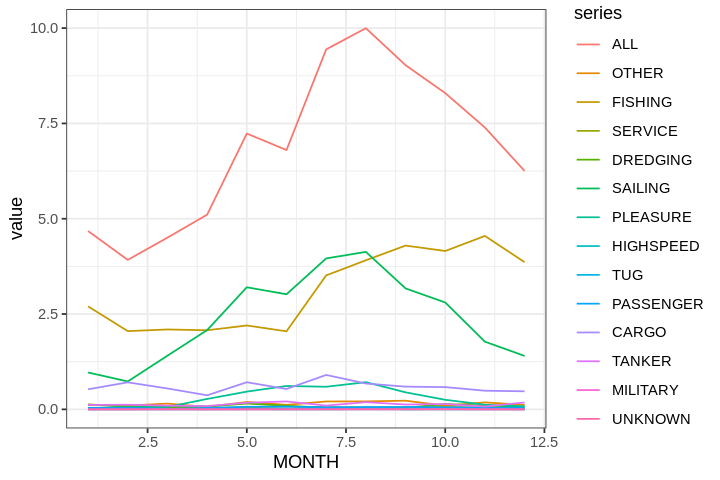

In [0]:
options(repr.plot.width=6, repr.plot.height=4)
df <- melt(data_csv ,  id.vars = 'MONTH', variable.name = 'series')
# ggplot(df, aes(MONTH,value)) + geom_line() + facet_grid(series ~ .) + theme_bw()
ggplot(df, aes(MONTH,value)) + geom_line(aes(colour = series)) + theme_bw()

# Working with data from EMODnet physics

## EMODnet physics WFS

The [WFS](https://geoserver.emodnet-physics.eu/geoserver/emodnet/ows?service=WFS&request=GetCapabilities&version=1.0.0) of the EMODnet Physics portal offers the possibility to identify the existing in-situ measurements for the region of interest (bbox).

In [0]:
# define a function to download point data as csv from the EMODnet physics WFS
getEMODnetPhysicsplatform<-function(name="EP_PLATFORMS_SLEV",xmin=-1000,xmax=1000,ymin=-1000,ymax=1000){
  name<-as.character(name)
  bbox<-paste(xmin,xmax,ymin,ymax,sep=",")
  con<-paste0("http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=",name,"&OUTPUTFORMAT=csv&bbox=",bbox)
  utils::download.file(con,"dat.csv", quiet = TRUE, mode = "wb")
  pipo<-utils::read.csv("dat.csv")
  if(ncol(pipo)<=1){
    return(data.frame())
  }
  else{
    xy<-strsplit(gsub("\\)","",gsub("POINT \\(","",pipo$position)),split=" ")
    fun1<-function(a){as.numeric(a[1])}
    fun2<-function(a){as.numeric(a[2])}
    pipo$y<-sapply(xy,fun1)
    pipo$x<-sapply(xy,fun2)
    print(con)
    return(pipo)
  }

}

# define a function to combine different data layers in a dataframe
getEMODnetPhysicsplatformall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9){
  physics <- data.frame()
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_SLEV", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_SLEV", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_WIND", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_WIND", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_WAVE", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_WAVE", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_TEMP", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_TEMP", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_HCXX", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_HCXX", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_MO", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_MO", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_HFR", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_HFR", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_FB", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_FB", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_GL", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_GL", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }

return(physics)
}

# get the data in the MPA
physics<-getEMODnetPhysicsplatformall(xmin,xmax,ymin,ymax)

[1] "http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=EP_PLATFORMS_SLEV&OUTPUTFORMAT=csv&bbox=45.656434726,-2.08542634399993,46.431984179,-1.08908527599993"
[1] "http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=EP_PLATFORMS_WIND&OUTPUTFORMAT=csv&bbox=45.656434726,-2.08542634399993,46.431984179,-1.08908527599993"
[1] "http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=EP_PLATFORMS_WAVE&OUTPUTFORMAT=csv&bbox=45.656434726,-2.08542634399993,46.431984179,-1.08908527599993"
[1] "http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=EP_PLATFORMS_TEMP&OUTPUTFORMAT=csv&bbox=45.656434726,-2.08542634399993,46.431984179,-1.08908527599993"
[1] "http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=EP_

We now plot the EMODnet physics data on a map and export the data to a CSV file.


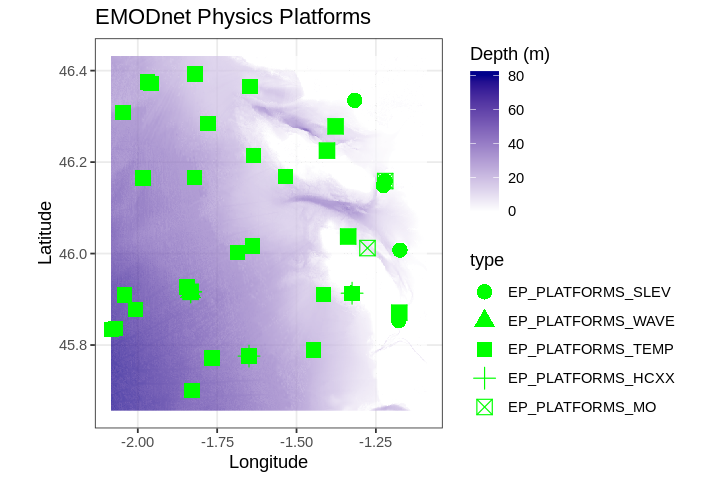

In [0]:
map<-ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_point(data= physics,aes(x=x,y=y,shape=type,group=type),colour="green", alpha=1, size=4) +
  #geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet Physics Platforms")+xlab("Longitude")+ylab("Latitude")
plot(map)



write.csv(physics, file = "EMODnetPhysics.csv")

## Alternative EMODnet physics web services

* UniqueURL (netCDF, metadata, )

  + https://www.emodnet-physics.eu/map/platinfo/piradar.aspx?platformid=10273
  + https://www.emodnet-physics.eu/map/platinfo/pidashboard.aspx?platformid=10273


* Service description @

  + https://www.emodnetphysics.eu/map/spi.aspx


* API (REST, SOAP) web services [latest 60 days of data]

  + www.emodnet-physics.eu/map/Service/WSEmodnet2.aspx
  + www.emodnet-physics.eu/map/service/WSEmodnet2.asmx
 
 
* OGC (WMS, WFS, …)

  + https://geoserver.emodnet-physics.eu/geoserver/emodnet/ows



* Opendap/THREDDS [HFR data, Ice, climatologies] (netCDF)

  + https://thredds.emodnet-physics.eu/thredds/catalog.html
  + Unidata's THREDDS Data Server (TDS) is a web server that provides metadata and data access for scientific datasets, using OPeNDAP, OGC WMS and WCS, HTTP, and other remote data access protocols.


* ERDDAP [latest 60 days of data]

  + https://erddap.emodnet-physics.eu/erddap/index.html
  + ERDDAP is a data server that gives you a simple, consistent way to download subsets of scientific datasets in common file formats and make graphs and maps. This particular ERDDAP installation has oceanographic data (for example, data from satellites and buoys).


* Widgets:

  + https://www.emodnet-physics.eu/Map/Charts/PlotDataTimeSeries.aspx?paramcode=TEMP&platid=8427&timerange=7

<iframe src ="https://www.emodnet-physics.eu/Map/Charts/PlotDataTimeSeries.aspx?paramcode=TEMP&platid=8427&timerange=7" height=500px width=800px />



# Working with data from EMODnet seabed habitats and EMODnet geology


## Access map layers with WMS

In this exercise, we will gather information on the seafloor using the WMS of EMODnet seabed habitats and EMODnet geology:

* https://ows.emodnet-seabedhabitats.eu/emodnet_view/ows?service=WMS&request=GetCapabilities&version=1.1.0

* https://drive.emodnet-geology.eu/geoserver/tno/wms?service=WMS&request=GetCapabilities&version=1.1.0

### EUNIS classification (EMODnet seabed habitats)

In the script below, we download the EUNIS classification map image.


In [0]:
# determine width and height of the WMS image to download
width <- 960
height <- as.integer(width * (extent(mpa)@ymax-extent(mpa)@ymin) / (extent(mpa)@xmax-extent(mpa)@xmin)) 

bbox <- paste(extent(mpa)@xmin, extent(mpa)@ymin, extent(mpa)@xmax, extent(mpa)@ymax, sep = ",")

# download the image
con <- paste0("https://ows.emodnet-seabedhabitats.eu/emodnet_view/ows?layers=eusm2019_group&bbox=", bbox,
"&service=WMS&format=image/png&interpolation=nearest&srs=EPSG:4326&request=GetMap&height=",height,"&width=",width,"")
download(con, "img.png", quiet = TRUE, mode = "wb")
img <- brick("img.png")

# set extent and determine map projection
img@extent@xmin <- xmin
img@extent@ymin <- ymin
img@extent@xmax <- xmax
img@extent@ymax <- ymax
proj4string(img)<-CRS("+proj=longlat +datum=WGS84")

Now we can add the downloaded and georeferenced image to our MPA map.

Regions defined for each Polygons


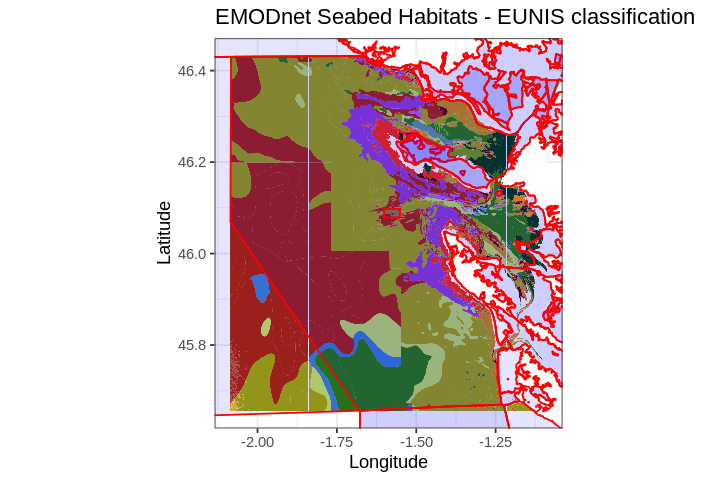

In [0]:
# define fucntion to plot the image
rggbplot <- function(inRGBRst,npix=NA,scale = 'lin'){
 
  rgblinstretch <- function(rgbDf){
    maxList <- apply(rgbDf,2,max)
    minList <- apply(rgbDf,2,min)
    temp<-rgbDf
    for(i in c(1:3)){
      temp[,i] <- (temp[,i]-minList[i])/(maxList[i]-minList[i])
    }
    return(temp)
  }
 
  rgbeqstretch<-function(rgbDf){
 
    temp<-rgbDf
    for(i in c(1:3)){
      unique <- na.omit(temp[,i])
      if (length(unique>0)){
        ecdf<-ecdf(unique)
        temp[,i] <- apply(temp[,i,drop=FALSE],2,FUN=function(x) ecdf(x))
      }
    }
    return(temp)
  }
 

      npix <- ncell(inRGBRst)

  x <- sampleRegular(inRGBRst, size=npix, asRaster = TRUE)
  dat <- as.data.frame(x, xy=TRUE)
  colnames(dat)[3:5]<-c('r','g','b')
 
  if(scale=='lin'){
    dat[,3:5]<- rgblinstretch(dat[,3:5])
  } else if(scale=='stretch'){
    dat[,3:5]<- rgbeqstretch(dat[,3:5])
  }
  p <- ggplot()+ geom_tile(data=dat, aes(x=x, y=y, fill=rgb(r,g,b))) + scale_fill_identity()
 
}

# draw the map
map <- rggbplot(img) +
  theme_bw() +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  ggtitle("EMODnet Seabed Habitats - EUNIS classification")+xlab("Longitude")+ylab("Latitude")
map

### Biological zone (EMODnet seabed habitats)

In the script below, we download the biological zone map image.

In [0]:
# determine width and height of the WMS image to download
width <- 960
height <- as.integer(width * (extent(mpa)@ymax-extent(mpa)@ymin) / (extent(mpa)@xmax-extent(mpa)@xmin)) 

bbox <- paste(extent(mpa)@xmin, extent(mpa)@ymin, extent(mpa)@xmax, extent(mpa)@ymax, sep = ",")

# download the image
con <- paste0("https://ows.emodnet-seabedhabitats.eu/emodnet_view/ows?layers=eusm2019_bio_group&bbox=", bbox,
"&service=WMS&format=image/png&interpolation=nearest&srs=EPSG:4326&request=GetMap&height=",height,"&width=",width,"")
download(con, "img.png", quiet = TRUE, mode = "wb")
img <- brick("img.png")

# set extent and determine map projection
img@extent@xmin <- xmin
img@extent@ymin <- ymin
img@extent@xmax <- xmax
img@extent@ymax <- ymax
proj4string(img)<-CRS("+proj=longlat +datum=WGS84")

Now we can add the downloaded and georeferenced image to our MPA map.

Regions defined for each Polygons


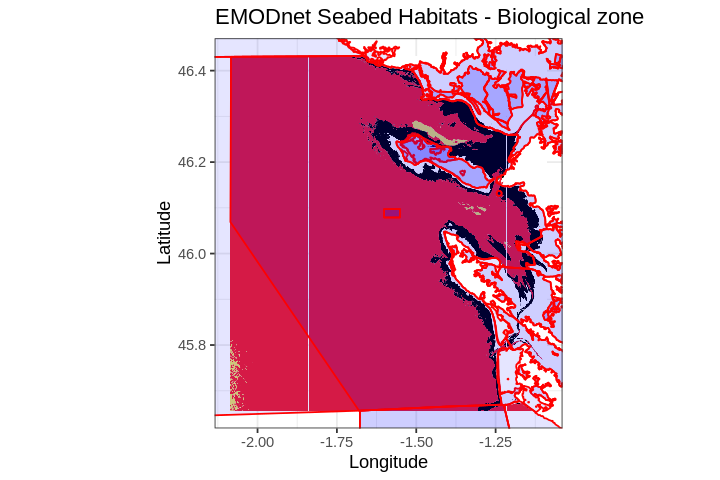

In [0]:
# draw the map
map <- rggbplot(img) +
  theme_bw() +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  ggtitle("EMODnet Seabed Habitats - Biological zone")+xlab("Longitude")+ylab("Latitude")
map

### Seabed substrate (EMODnet geology)

In the script below, we download the seabed substrate map image.

In [0]:
# determine width and height of the WMS image to download
width <- 960
height <- as.integer(width * (extent(mpa)@ymax-extent(mpa)@ymin) / (extent(mpa)@xmax-extent(mpa)@xmin)) 

bbox <- paste(extent(mpa)@xmin, extent(mpa)@ymin, extent(mpa)@xmax, extent(mpa)@ymax, sep = ",")

# download the image
con <- paste0("https://drive.emodnet-geology.eu/geoserver/gtk/wms?layers=seabed_substrate_1m&bbox=", bbox,
"&service=WMS&format=image/png&interpolation=nearest&srs=EPSG:4326&request=GetMap&height=",height,"&width=",width,"")
download(con, "img.png", quiet = TRUE, mode = "wb")
img <- brick("img.png")

# set extent and determine map projection
img@extent@xmin <- xmin
img@extent@ymin <- ymin
img@extent@xmax <- xmax
img@extent@ymax <- ymax
proj4string(img)<-CRS("+proj=longlat +datum=WGS84")

Now we can add the downloaded and georeferenced image to our MPA map.

Regions defined for each Polygons


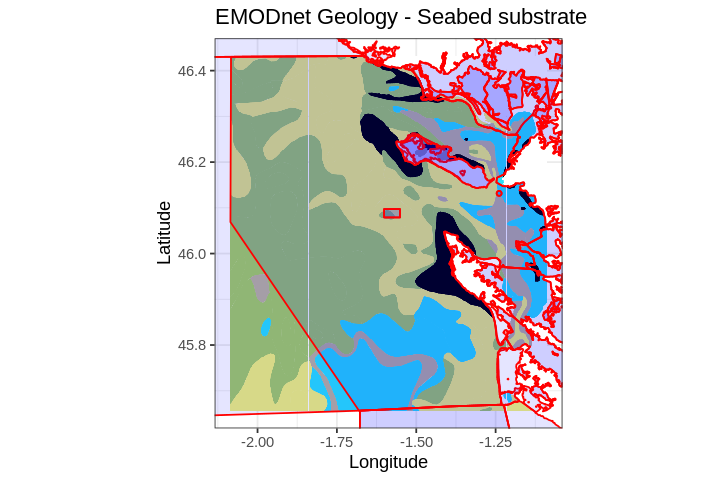

In [0]:
# draw the map
map <- rggbplot(img) +
  theme_bw() +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  ggtitle("EMODnet Geology - Seabed substrate")+xlab("Longitude")+ylab("Latitude")
map

## Access point data with WFS

In this exercise we access the coastal migration point data from the EMODnet geology WFS within the desired region of interest (the MPA) as a csv file.

In [0]:
# define a function to download the WFS data as a csv file 
getEMODnetCoastalMigration<-function(name="tno:coastal_migration_satellite_0_40k",xmin=-1000,xmax=1000,ymin=-1000,ymax=1000){
  name<-as.character(name)
  bbox<-paste(xmin,xmax,ymin,ymax,sep=",")
  con<-paste0("https://drive.emodnet-geology.eu/geoserver/tno/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=",
  name,"&OUTPUTFORMAT=csv&bbox=",bbox)
  utils::download.file(con,"dat.csv", quiet = TRUE, mode = "wb")
  pipo<-utils::read.csv("dat.csv")
  if(ncol(pipo)<=1){
    return(data.frame())
  }
  else{
    xy<-strsplit(gsub("\\)","",gsub("POINT \\(","",pipo$geom)),split=" ")
    fun1<-function(a){as.numeric(a[1])}
    fun2<-function(a){as.numeric(a[2])}
    pipo$y<-sapply(xy,fun1)
    pipo$x<-sapply(xy,fun2)
    print(con)
    return(pipo)
  }
}

# function to format the dataframe
getEMODnetCoastalMigrationformall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9){
  geology <- data.frame()
  rez0 <- getEMODnetCoastalMigration("tno:coastal_migration_satellite_0_40k", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    geology1 <- data.frame(type = "tno:coastal_migration_satellite_0_40k", Migration = rez0$changerate, name = rez0$id,
    x = rez0$x, y = rez0$y)
    geology <- rbind(geology, geology1)
    rm(rez0)
  }
  return(geology)
}

# get the data
geology<-getEMODnetCoastalMigrationformall(xmin,xmax,ymin,ymax)

[1] "https://drive.emodnet-geology.eu/geoserver/tno/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=tno:coastal_migration_satellite_0_40k&OUTPUTFORMAT=csv&bbox=45.656434726,-2.08542634399993,46.431984179,-1.08908527599993"


We now plot the coastal migration data on a map and export the data to a CSV file.

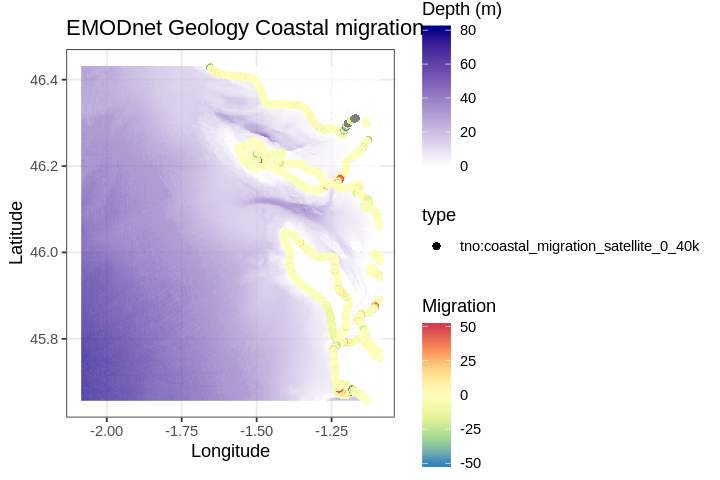

In [0]:
# make a map
map<-ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_point(data= geology,aes(x=x,y=y,shape=type,group=type,color=Migration), alpha=1, size=2) +
  #scale_shape_manual(name = "Coastal Migration", values = c(4)) + 
  scale_colour_distiller(palette = "Spectral", limits = c(-50, 50)) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet Geology Coastal migration")+xlab("Longitude")+ylab("Latitude")

plot(map)

# export the data to csv
write.csv(geology, file = "EMODnetGeology-CoastalMigration.csv")

# Working with data from EMODnet biology 

During this exercise we focus on the "Estuaires picards et mer d'Opale" Marine Protected Area (MPA) in France. The shapefile for this area can be downloaded from the [World Database on Protected Areas (WDPA)](https://www.protectedplanet.net/estuaires-picards-et-mer-d-opale-marine-nature-park).

In [0]:
# download and unzip the shapefile
con = "https://www.protectedplanet.net/downloads/WDPA_Jan2020_protected_area_555559631?type=shapefile"
download(con,"shapefile.zip", mode = "wb")
unzip("shapefile.zip",exdir="MPA2")
# read it into R
mpa = readOGR("MPA2","WDPA_Jan2020_protected_area_555559631-shapefile-polygons")
# get the spatial extent of the MPA
xmin <- extent(mpa)@xmin
ymin <- extent(mpa)@ymin
xmax <- extent(mpa)@xmax
ymax <- extent(mpa)@ymax

OGR data source with driver: ESRI Shapefile 
Source: "/content/MPA2", layer: "WDPA_Jan2020_protected_area_555559631-shapefile-polygons"
with 1 features
It has 28 fields


We make some maps to show the location of the MPA.

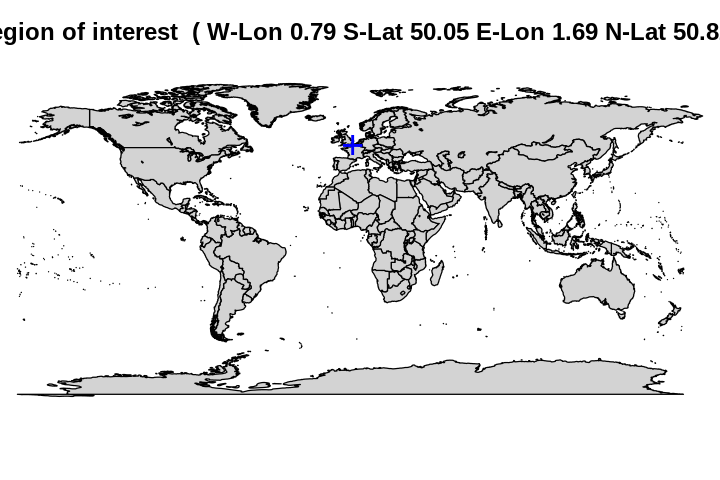

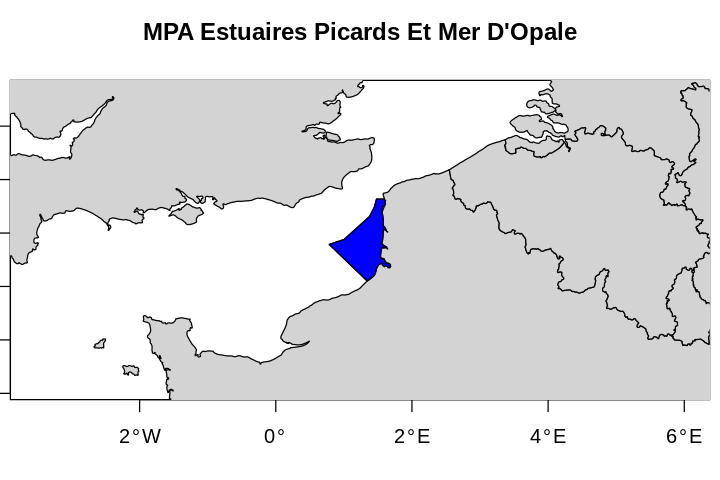

In [0]:
# Localisation at global scale
map("worldHires",col="light grey",fill=T)
points(coordinates(mpa),cex=2,col="blue",pch="+")
title(paste("Region of interest ",
            "( W-Lon",round(xmin,2),
            "S-Lat",round(ymin,2),
            "E-Lon",round(xmax,2),
            "N-Lat",round(ymax,2),")"),cex=.5)

# Localisation at local scale
plot(mpa,xlim=c(xmin-1,xmax+1),ylim=c(ymin-1,ymax+1),axes=T,col="red")
map("worldHires",add=T,col="light grey",fill=T)
plot(mpa,add=T,col="blue")
title(paste("MPA",mpa$ORIG_NAME),cex=.5)

We again extract the bathymetry using the function defined in exercise 1.

In [0]:
# get the bathymetry data for the MPA
bathy_img <- getbathymetry(name = "emodnet:mean", xmin, xmax, ymin, ymax)
bathy <- as.data.frame(as(bathy_img, "SpatialPixelsDataFrame"))

[1] "https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=0.785219445000052,50.0517285330001,1.68869100000006,50.817680555&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333"


## Access polygon data with WFS

Using the EMODnet biology WFS we can get the zooplankton abundances for different grid cells within the MPA (bbox). To calculate statistics of the abundance data over a particular period and a particular season, we can download it as a geoJSON file.

In [0]:
# set the request parameters
reg.name = 36317
spec.name = 'Acartia_spp'
trend_start = 2004
trend_end = 2013
season.code = 1
bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")
type.name='Emodnetbio:OOPS_products_vliz'

# build the WFS URL
url<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=json"
full_url<-paste(url,"&viewParams=;startYearCollection:",trend_start,";mrgid:",reg.name,";scientificName:",spec.name,";season:",season.code,"&typeName=",type.name,"&BBOX=",bbox,sep="")

# get the data as a geoJSON file
library("rjson")
json_data <- fromJSON(file=full_url)
# to display the file
# str(json_data)
# to save
# geojson_write(json_data, file = 'MyJson.geojson') #bogue ?

test<-json_data[['features']]
mean=0 
l<- length(test)
for (i in 1:l){
tests<-test[[l]]
mean<-mean+tests$properties$measurementValue
}
mean_value_season1<-mean/l
mean_value_season1

[1] 0.450216

We can also visualise the extent of the zooplankton abundance grid cell by downloading the data as a zipped shapefile and plotting it on a map.


OGR data source with driver: ESRI Shapefile 
Source: "/content", layer: "OOPS_products_vlizPolygon"
with 62 features
It has 10 fields


Regions defined for each Polygons


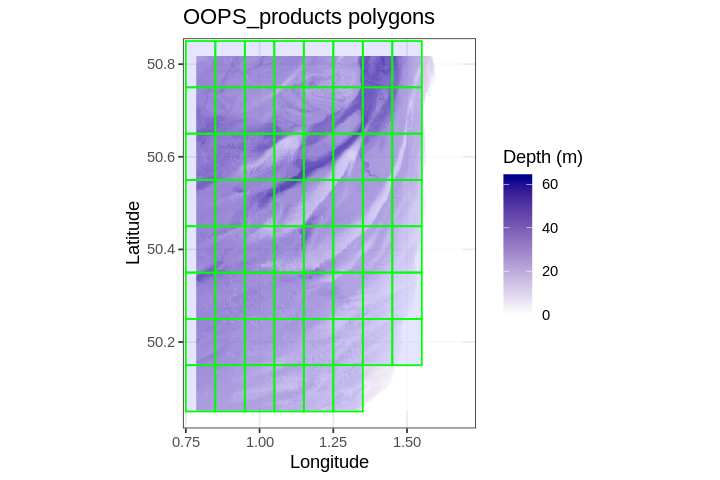

In [0]:
# build the WFS URL
url<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=shape-zip"
full_url<-paste(url,"&viewParams=;startYearCollection:",trend_start,";mrgid:",reg.name,";scientificName:",spec.name,";season:",season.code,"&typeName=",type.name,"&BBOX=",bbox,sep="")

# get the data as a zipped shapefile
download(full_url, dest="shapefile.zip", mode="wb") 
unzip("shapefile.zip", overwrite = TRUE)
OOPS_products <- readOGR(dsn = ".", layer = "OOPS_products_vlizPolygon")

# plot on a map
map<-ggplot()+
  theme_bw()+
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank())+
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75)+
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)")+
  geom_polygon(data=OOPS_products,aes(x=long,y=lat,group=group, fill="OOPS_products"),colour="green",fill="blue",alpha=.1)+
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax))+
ggtitle("OOPS_products polygons")+xlab("Longitude")+ylab("Latitude")
plot(map)

# export to a shapefile which can then be visualised in e.g. QGIS
writeOGR(OOPS_products,"OOPS_products","OOPS_products_bbox",driver="ESRI Shapefile",overwrite_layer = TRUE)

Alternatively, we can also download the zooplankton abundance grid cell as geoJSON.

[1] "http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=json&viewParams=;startYearCollection:2004;mrgid:36317;scientificName:Acartia_spp;season:1&typeName=Emodnetbio:OOPS_products_vliz&BBOX=0.785219445000052,50.0517285330001,1.68869100000006,50.817680555"
OGR data source with driver: GeoJSON 
Source: "/tmp/RtmpEyqWZp/file7afa13ca5", layer: "file7afa13ca5"
with 62 features
It has 12 fields, of which 1 list fields


Regions defined for each Polygons


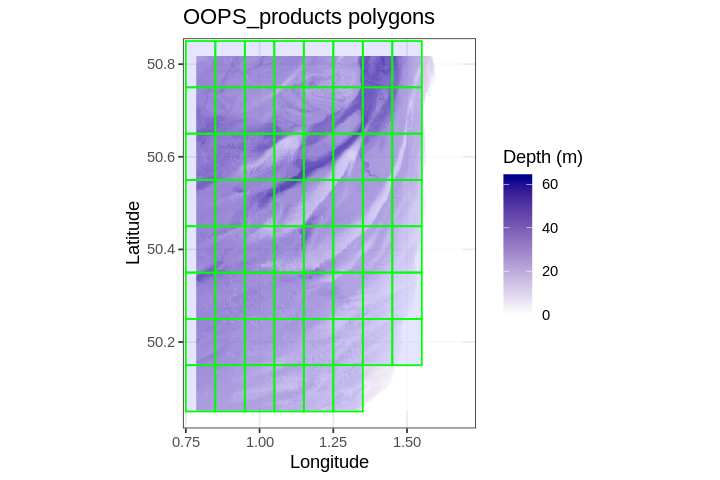

In [0]:
# function to read GeoJSON
getgeojson<-function(name="Emodnetbio:OOPS_products_vliz",xmin=-1,xmax=1,ymin=49,ymax=50){
  reg.name = 36317 #label="Greater North Sea"
  trend_start = 1958 #startDate
  trend_end = 2013 #endDate
  spec.name = 'Acartia_spp'
  trend_start = 2004
  trend_end = 2013
  season.code = 1
  bbox<-paste(xmin,ymin,xmax,ymax,sep=",")
  
  url<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=json"
  con<-paste(url,"&viewParams=;startYearCollection:",trend_start,";mrgid:",reg.name,";scientificName:",spec.name,";season:",season.code,"&typeName=",name,"&BBOX=",bbox,sep="")
  print(con)
  temp <- tempfile()
  download(con,temp)
  ogrInfo(dsn=temp)
  layer<-readOGR(dsn=temp)
  return(layer)
}
OOPS_products<-getgeojson(name="Emodnetbio:OOPS_products_vliz",xmin,xmax,ymin,ymax)

map <- ggplot()+
  theme_bw()+
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_polygon(data=OOPS_products,aes(x=long,y=lat,group=group,fill="OOPS_products"),colour="green",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("OOPS_products polygons")+xlab("Longitude")+ylab("Latitude")

plot(map)

## Access time series data with WFS

Using WFS, we can also access the zooplankton abundance time series as a csv file.


In [0]:
# determine parameters
reg.name = 36317 #label="Greater North Sea"
spec.name = 'Acartia_spp' #species
trend_start = 1958 #startDate
trend_end = 2013 #endDate

# construct WFS url
mainurl<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=Emodnetbio:OOPS_summaries&outputFormat=csv&SQL_FILTER=startYearCollection-endYearCollection=0"
fullurl<-paste(mainurl,"ANDscientificName='",spec.name,"'ANDmrgid=",reg.name,sep="")

# get the data
datans <- read.csv(file= fullurl, header=TRUE)

We now analyse the time series seasonality and trends using the `stl()` loess seasonal decomposition function.

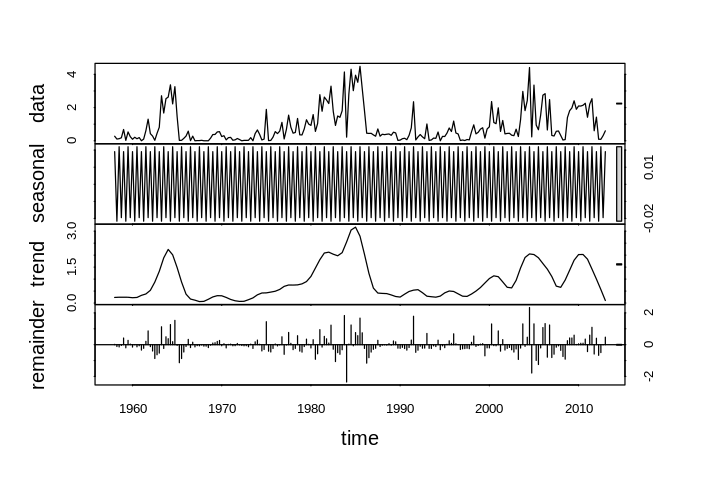

In [0]:
levels(datans$scientificName)[levels(datans$scientificName)=="RatioLS copepods"] <- "Large/Small copepod ratio"
seldata<-datans[with(datans, order(datans$startYearCollection,datans$season)),]
# convert to a time series object
tscf<-ts(data=seldata$avg_ab, start=trend_start, end=trend_end, frequency=4)
# decompose the time series
fitstl<-stl(tscf,s.window="periodic",t.window=15)
plot(fitstl)

# Search for data using EMODnet Catalogue Service

Using the EMODnet Catalogue Service for the Web (CSW), we can query and search collections of metadata for data, services and information objects related to the EMODnet Marine Data. In the example below, we use the `XML` package to send a request to the CSW endpoint, parse the XML response and store it in a dataframe.

In [0]:
# CSW request
url_getcapa="http://www.emodnet.eu/geonetwork/emodnet/eng/csw?REQUEST=GetRecords&SERVICE=CSW&VERSION=2.0.2&ELEMENTSETNAME=summary&OUTPUTSCHEMA=http://www.opengis.net/cat/csw/2.0.2&CONSTRAINTLANGUAGE=FILTER&CONSTRAINT_LANGUAGE_VERSION=1.1.0&RESULTTYPE=results&TYPENAMES=csw:Record&CONSTRAINT=%3Cogc:Filter%20xmlns:ogc=%22http://www.opengis.net/ogc%22%3E%3Cogc:PropertyIsEqualTo%3E%3Cogc:PropertyName%3Edc:type%3C/ogc:PropertyName%3E%3Cogc:Literal%3Edataset%3C/ogc:Literal%3E%3C/ogc:PropertyIsEqualTo%3E%3C/ogc:Filter%3E&maxRecords=1000"


# get and parse response to a dataframe
response = xmlParse(url_getcapa)
response = xmlToList(response)
results = data.frame()
for(record in response$SearchResults[names(response$SearchResults) == "SummaryRecord"]){
  # cast to datafame, negating empty fields
  df = as.data.frame(Filter(Negate(is.null),record),  stringsAsFactors = FALSE)
  # combine multiple subjects into 1 column
  if(sum(grepl("subject",names(df))) > 1){
    df = unite(df,"subject",contains("subject"), sep = ", ", remove = TRUE)
  }
  # combine multiple formats into 1 column
  if(sum(grepl("format",names(df))) > 1){
    df = unite(df,"format",contains("format"), sep = ", ", remove = TRUE) 
  }
  results = bind_rows(results,df)
}

Now that we have all the records stored in a dataframe, we can perform detailed queries.

In [0]:
# look for Records with keyword 'Habitat'
results %>%
  filter(grepl("Habitat",results$subject)) %>%
  # limit printing length of abstract
  mutate(abstract = paste(substring(abstract,0,80),"...")) %>%
  knitr::kable(floating.environment="sidewaystable") %>%
  kable_styling(bootstrap_options = c("condensed","striped","hover")) %>%
  as.character() %>% display_html()

identifier 
 title 
 type 
 subject 
 format 
 modified 
 abstract 
 relation 
 
 
 
 
 8f8a9aa2-528b-4494-ab88-74633dfcf446 
 EMODnet Human Activities: Protected Areas 
 dataset 
 Area management/restriction/regulation zones and reporting units, Land cover, Protected sites, Habitats and biotopes, protected area, natural area, natural areas protection, environment 
 unknown 
 2016-04-13 
 The dataset on marine and coastal protected areas in the EU was created in 2014 ... 
 NA 
 
 
 1cf5882d-4feb-4cf7-9eb5-6a542af72773 
 EMODnet Human Activities, Environment, CDDA 
 dataset 
 Area management/restriction/regulation zones and reporting units, Land cover, Protected sites, Habitats and biotopes, protected area, natural area, natural areas protection, environment 
 unknown 
 2018-04-30 
 The Common Database on Designated Areas (CDDA) was created in 2014 by Cogea for ... 
 NA 
 
 
 234c2894-a2a3-4345-a1cb-e2dd69e1b5e7 
 EMODnet Human Activities, Environment, Natura 2000 
 dataset 
 Area management/restriction/regulation zones and reporting units, Land cover, Protected sites, Habitats and biotopes, protected area, natural area, natural areas protection, environment 
 unknown 
 2018-04-30 
 The dataset on Natura 2000 sites was created in 2014 by Cogea for the European M ... 
 NA 
 
 
 02a444c8-bd2d-4e15-8e69-806059103760 
 EUSeaMap2 (2016) Broad-Scale Predictive Habitat Map 
 dataset 
 Habitats and biotopes, biota, environment, oceans 
 Web Mapping Service 
 NA 
 Output of the 2016 EUSeaMap broad-scale predictive model, produced by EMODnet Se ... 
 NA 
 
 
 39b23bdb-1f0b-412f-9746-bd816bb9c11e 
 EUSeaMap2 (2016) Broad-Scale Predictive Habitat Map - Confidence 
 dataset 
 Habitats and biotopes, biota, environment, oceans 
 Web Mapping Service 
 2017-06-12 
 Confidence in the full output of the 2016 EUSeaMap broad-scale predictive model, ... 
 02a444c8-bd2d-4e15-8e69-806059103760 
 
 
 d23d0516-6ff4-4fb8-bf78-c11991cef78b 
 EUSeaMap2 (2016) Broad-Scale Predictive Habitat Map - MSFD Benthic Broad Habitat Types 
 dataset 
 Habitats and biotopes, Marine Strategy Framework Directive, Predominant habitats, biota, environment, oceans 
 Web Mapping Service 
 NA 
 Output of the 2016 EUSeaMap broad-scale predictive model, produced by EMODnet Se ... 
 02a444c8-bd2d-4e15-8e69-806059103760 
 
 
 735ea8c9-5bb7-48a2-a41d-57e521f97ae8 
 Areal Extent of Live Hard Coral (Essential Ocean Variable) 
 dataset 
 Habitats and biotopes, Downloadable Data, Downloadable Data, biota, geoscientificInformation, oceans 
 Shapefile 
 NA 
 This layer shows the current known extent of Live Hard Coral in European waters, ... 
 NA 
 
 
 913a0ee4-45d7-45aa-8de2-3d31af0f7c0e 
 Areal Extent of Macroalgal Canopy (Essential Ocean Variable) 
 dataset 
 Habitats and biotopes, Downloadable Data, Downloadable Data, geoscientificInformation, biota, oceans 
 Shapefile 
 NA 
 This layer shows the current known extent of macroalgal forests in European wate ... 
 NA 
 
 
 39746d9c-4220-425c-bc26-7cb3056c36a5 
 Areal Extent of Seagrass Meadows (Essential Ocean Variable) 
 dataset 
 Habitats and biotopes, Downloadable Data, Downloadable Data, biota, geoscientificInformation, oceans 
 Shapefile 
 NA 
 This layer shows the current known extent of Seagrass meadows in European waters ... 
 NA

In [0]:
# look for Records with keyword 'substrate'
results %>%
  filter(grepl("substrate",results$subject)) %>%
  mutate(abstract = paste(substring(abstract,0,80),"...")) %>%  # limit printing length of abstract
  knitr::kable(floating.environment="sidewaystable") %>%
  kable_styling(bootstrap_options = c("condensed","striped","hover")) %>%
  as.character() %>% display_html()

identifier 
 title 
 type 
 subject 
 format 
 modified 
 abstract 
 relation 
 
 
 
 
 c12369240c9e64f852c24aa5830d60ab1906dcc1 
 Seabed Substrate Map 1:50k Seabed Substrate Map 1:50k Seabed Substrate Map 1:50k 
 dataset 
 features, seabed_substrate_multiscale_50k, features, seabed_substrate_multiscale_50k, features, seabed_substrate_multiscale_50k, oceans 
 NA 
 NA 
 Seabed substrate map of the European marine areas including (e.g. the Baltic Sea ... 
 NA 
 
 
 83ee2bd512b2cc98e90898a1ea3f1ccc6ee54a37 
 Seabed Substrates 1:250k Seabed Substrates 1:250k Seabed Substrates 1:250k 
 dataset 
 features, seabed_substrate_250k, features, seabed_substrate_250k, features, seabed_substrate_250k, oceans 
 NA 
 NA 
 Seabed substrate map of the European marine areas including (e.g. the Baltic Sea ... 
 NA 
 
 
 376300fb451c7a8b2b4ba3cf3fb6a16bd4a5fc46 
 Seabed Substrates 1:1M Seabed Substrates 1:1M Seabed Substrates 1:1M 
 dataset 
 features, seabed_substrate_1m, features, seabed_substrate_1m, features, seabed_substrate_1m, oceans 
 NA 
 NA 
 Seabed substrate map of the European sea areas (e.g. the Baltic Sea, the Barents ... 
 NA 
 
 
 a434a2bb3e860a1c5485124055c4458e7fdfe08b 
 Seabed Substrates 1:100k Seabed Substrates 1:100k Seabed Substrates 1:100k 
 dataset 
 seabed_substrate_100k, features, seabed_substrate_100k, features, seabed_substrate_100k, features, oceans 
 NA 
 NA 
 Seabed substrate map of the European marine areas including (e.g. the Baltic Sea ... 
 NA